 # Import Packages


In [3]:
# !pip3 install matplotlib

In [1]:
# Hide warnings if there are any
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession
from pyspark import SparkConf
from sparkxarray import reader
import numpy as np
import xarray as xr
import dask
from __future__ import print_function
from glob import glob
import pandas as pd
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt

# Setup PySpark Session / Context


In [2]:
spark = SparkSession.builder \
    .appName('spark_cluster_mode') \
    .master("spark://spark-master:7077") \
    .config("spark.driver.maxFrameSize", "100000000") \
    .config("spark.executor.maxResultSize", "100000000") \
    .config("spark.ui.showConsoleProgress", "true") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/06 15:27:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sc = spark.sparkContext

# Load Data

In [4]:
_10m_u = "/app/data/10m_u_component_of_wind_2002_2022.nc"
_10m_v = "/app/data/10m_v_component_of_wind_2002_2022.nc"
_2m_t = "/app/data/2m_temperature_2002_2022.nc"
snow_cover = "/app/data/snow_cover_2002_2022.nc"
snow_density = "/app/data/snow_density_2002_2022.nc"
snow_depth = "/app/data/snow_depth_2002_2022.nc"
sdwe = "/app/data/snow_depth_water_equivalent_2002_2022.nc"
snowfall=  "/app/data/snowfall_2002_2022.nc"
snowmelt = "/app/data/snowmelt_2002_2022.nc"
surface_pressure = "/app/data/surface_pressure_2002_2022.nc"
total_precipitation = "/app/data/total_precipitation_2002_2022.nc"

# NcPlot

In [18]:
# !pip install ncplot

In [10]:
# !pip install git+https://github.com/pmlmodelling/ncplot.git

In [19]:
# import ncplot.xarray
import  xarray as xr

dss = xr.open_dataset(total_precipitation)



In [21]:
# dss.ncplot.view()

In [598]:
# from ncplot import ncplot
# ncplot(_2m_t)

In [600]:
# ncplot.ncplot(dss, vars=None)


In [602]:
# !ncplot _2m_t

# Data Global  View 

ncdump est un utilitaire de base qui fait partie de la distribution de netCDF.
ncdump -h <file.nc> liste les métadonnées du fichier netCDF,

ncdump -c <file.nc> liste les métadonnées et les variables de coordonnées,

ncdump <file.nc> liste les métadonnées et toutes les données. Attention : la sortie peut être très volumineuse.

ncdump -v lat,time mslp.nc To look at a subset of the data by specifying one or more variables:

ncdump -t -v lat,time mslp.nc To see times in human-readable form:

ncdump -k mslp.nc To look at what kind of netCDF data is in the file (classic, 64-bit offset, netCDF-4, or netCDF-4 classic model):

In [274]:
# !apt-get install -y netcdf-bin

In [7]:
# Explore file metadata with ncdump
!ncdump -h /app/data/snow_depth_water_equivalent_2002_2022.nc

netcdf snow_depth_water_equivalent_2002_2022 {
dimensions:
	longitude = 34 ;
	latitude = 20 ;
	time = 7670 ;
variables:
	float longitude(longitude) ;
		longitude:units = "degrees_east" ;
		longitude:long_name = "longitude" ;
	float latitude(latitude) ;
		latitude:units = "degrees_north" ;
		latitude:long_name = "latitude" ;
	int time(time) ;
		time:units = "hours since 1900-01-01 00:00:00.0" ;
		time:long_name = "time" ;
		time:calendar = "gregorian" ;
	short sd(time, latitude, longitude) ;
		sd:scale_factor = 3.62135212401007e-06 ;
		sd:add_offset = 0.118657223695314 ;
		sd:_FillValue = -32767s ;
		sd:missing_value = -32767s ;
		sd:units = "m of water equivalent" ;
		sd:long_name = "Snow depth" ;
		sd:standard_name = "lwe_thickness_of_surface_snow_amount" ;

// global attributes:
		:Conventions = "CF-1.6" ;
		:history = "2023-05-23 14:40:26 GMT by grib_to_netcdf-2.24.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/tmp/8ceae99d-a85e-4bef-be42-6ca83add993e-adaptor.mars.inter

In [8]:
#liste les métadonnées et les variables de coordonnées
!ncdump -c /app/data/10m_u.nc

ncdump: /app/data/10m_u.nc: No such file or directory


# read NetCDF files as RDD using  spark-xarray


In [9]:
from sparkxarray.reader import ncread

rdd = ncread(sc, total_precipitation, mode='single', partition_on=['time'], partitions=100)

In [10]:
type(rdd)

pyspark.rdd.PipelinedRDD

In [22]:
tt = rdd.count()
tt

7670

# create a new RDD with elements containing values from our region of interest 

In [425]:
def get_region_of_interest(dset):
    return dset.sel(latitude=slice(33.23, 32.93), longitude=slice(-5.06, -8.26))

In [426]:
region_of_interest = rdd.map(get_region_of_interest).cache()

In [427]:
region_of_interest.count()

7670

In [428]:
tt = region_of_interest.take(10)
tt

[<xarray.Dataset>
 Dimensions:    (longitude: 0, latitude: 4, time: 1)
 Coordinates:
   * longitude  (longitude) float32 
   * latitude   (latitude) float32 33.23 33.13 33.03 32.93
   * time       (time) datetime64[ns] 2002-01-01T12:00:00
 Data variables:
     tp         (time, latitude, longitude) float32 ...
 Attributes:
     Conventions:  CF-1.6
     history:      2023-05-23 16:03:23 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...,
 <xarray.Dataset>
 Dimensions:    (longitude: 0, latitude: 4, time: 1)
 Coordinates:
   * longitude  (longitude) float32 
   * latitude   (latitude) float32 33.23 33.13 33.03 32.93
   * time       (time) datetime64[ns] 2002-01-02T12:00:00
 Data variables:
     tp         (time, latitude, longitude) float32 ...
 Attributes:
     Conventions:  CF-1.6
     history:      2023-05-23 16:03:23 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...,
 <xarray.Dataset>
 Dimensions:    (longitude: 0, latitude: 4, time: 1)
 Coordinates:
   * longitude  (longitude) float32 
   * latit

# Statistics:

# Global  smlt mean Calculation and plotting


In [474]:
smlt_rdd = ncread(sc, snowmelt, mode='single', partition_on=['time'], partitions=100)

In [475]:
def global_mean_smlt(dset):
    # Find mean snowmelt  for each latitude
    mean_smlt_lat = dset.smlt.mean(dim='longitude')

    # Find Weighted mean of those values
    num =(np.cos(dset.latitude) * mean_smlt_lat).sum(dim='latitude')
    denom = np.sum(np.cos(dset.latitude))

    # Find mean global snowmelt
    mean_global_smlt = num / denom

    return mean_global_smlt

In [476]:
global_mean_smlt = smlt_rdd.map(global_mean_smlt)
global_mean_smlt

PythonRDD[69] at RDD at PythonRDD.scala:53

In [477]:
mean_smlt = global_mean_smlt.collect()


In [478]:
mean_smlt[0]

<xarray.DataArray (time: 1)>
array([1.8752708e-06], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-01-01T12:00:00

In [479]:
a = xr.concat(mean_smlt[:], dim='time')

In [480]:
ds = a.to_dataset(name="mean_smlt")
ds

<xarray.Dataset>
Dimensions:    (time: 7670)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01T12:00:00 ... 2022-12-31T12:00:00
Data variables:
    mean_smlt  (time) float32 1.875e-06 3.395e-06 ... 9.247e-08 4.894e-08

In [481]:
df = ds['mean_smlt'].to_dataframe()
df.head()

,mean_smlt
time,
2002-01-01 12:00:00,1.875271e-06
2002-01-02 12:00:00,3.394590e-06
2002-01-03 12:00:00,2.124185e-06
2002-01-04 12:00:00,1.443021e-06
2002-01-05 12:00:00,4.948234e-07


In [482]:
type(df)

pandas.core.frame.DataFrame

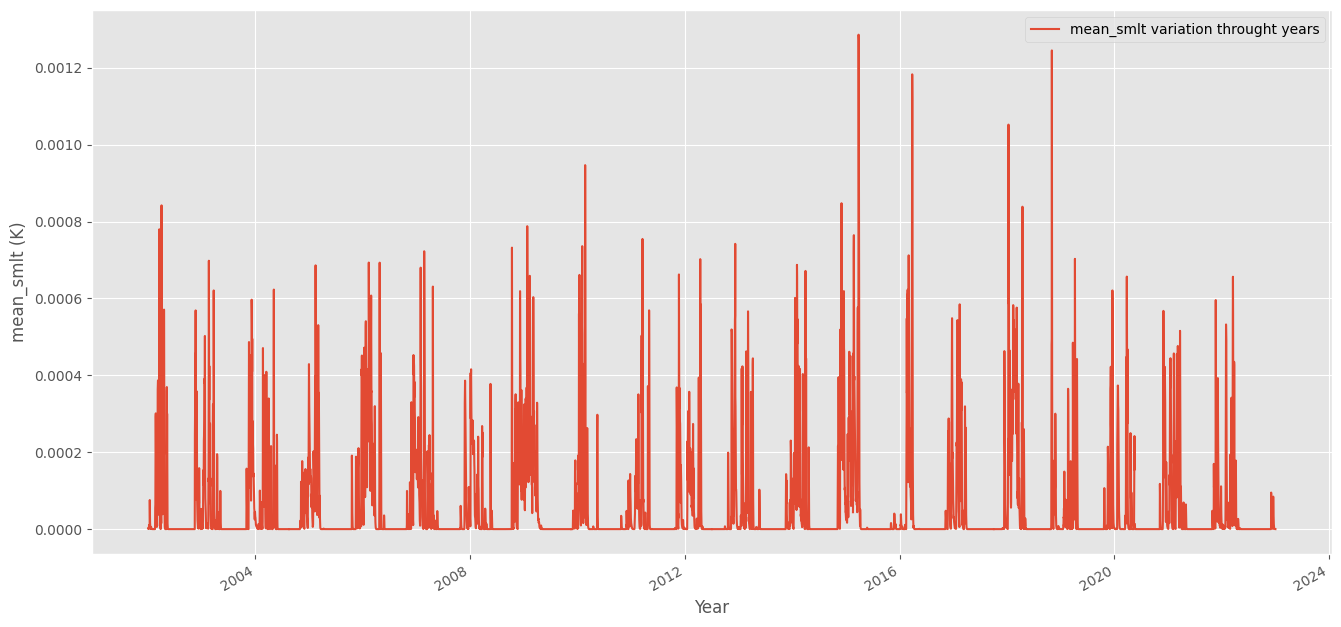

In [574]:
ax = df['mean_smlt'].plot(legend=True, label="mean_smlt variation throught years", figsize=(16, 8))
# ax = df_anom['mean_sst'].plot(legend=True, label="smoothed anom")
ax.set_xlabel("Year")
ax.set_ylabel("mean_smlt (K)")
plt.show()

# Global snow_depth mean Calculation and plotting

In [484]:
snow_depth_rdd = ncread(sc, snow_depth, mode='single', partition_on=['time'], partitions=100)

In [485]:
def global_mean_snow_depth(dset):
    # Find mean snowmelt  for each latitude
    mean_snow_depth_lat = dset.sde.mean(dim='longitude')

    # Find Weighted mean of those values
    num =(np.cos(dset.latitude) * mean_snow_depth_lat).sum(dim='latitude')
    denom = np.sum(np.cos(dset.latitude))

    # Find mean global snowmelt
    mean_global_snow_depth = num / denom

    return mean_global_snow_depth

In [486]:
global_mean_snow_depth = snow_depth_rdd.map(global_mean_snow_depth)

mean_snow_depth = global_mean_snow_depth.collect()


In [487]:
a = xr.concat(mean_snow_depth[:], dim='time')
ds = a.to_dataset(name="mean_snow_depth")
df_2 = ds['mean_snow_depth'].to_dataframe()
df_2.head()

,mean_snow_depth
time,
2002-01-01 12:00:00,0.000033
2002-01-02 12:00:00,0.000090
2002-01-03 12:00:00,0.000032
2002-01-04 12:00:00,0.000009
2002-01-05 12:00:00,0.000007


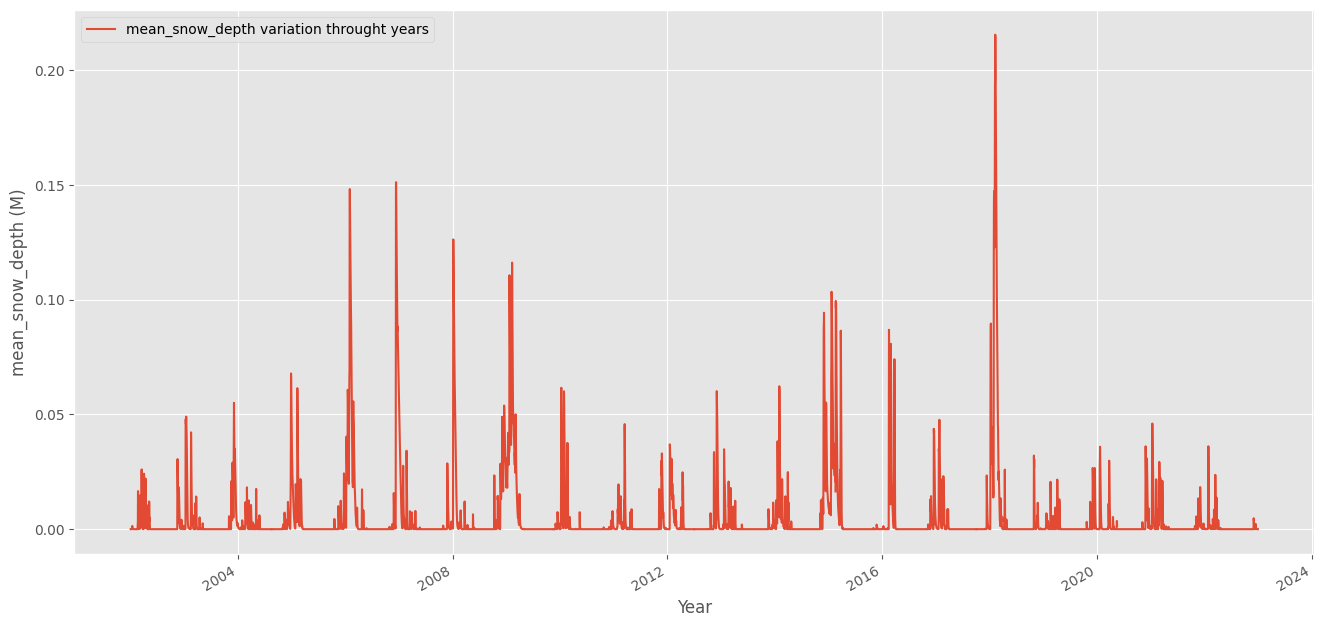

In [572]:
ax = df_2['mean_snow_depth'].plot(legend=True, label="mean_snow_depth variation throught years", figsize=(16, 8))
# ax = df_anom['mean_sst'].plot(legend=True, label="smoothed anom")
# ax_2 = df['mean_smlt'].plot(legend=True, label="mean_smlt variation throught years", figsize=(16, 8))
ax.set_xlabel("Year")
ax.set_ylabel("mean_snow_depth (M)")
# ax_2.set_ylabel("mean_mean_smlt (K)")

plt.show()

# Global Sdwe mean Calculation and plotting

In [566]:
sdwe_rdd = ncread(sc, sdwe, mode='single', partition_on=['time'], partitions=100)

In [567]:
def global_mean_sdwe(dset):
    # Find mean snowmelt  for each latitude
    mean_sdwe_lat = dset.sd.mean(dim='longitude')

    # Find Weighted mean of those values
    num =(np.cos(dset.latitude) * mean_sdwe_lat).sum(dim='latitude')
    denom = np.sum(np.cos(dset.latitude))

    # Find mean global snowmelt
    mean_global_sdwe = num / denom

    return mean_global_sdwe

In [568]:
global_mean_sdwe = sdwe_rdd.map(global_mean_sdwe)

mean_sdwe = global_mean_sdwe.collect()


In [569]:
a = xr.concat(mean_sdwe[:], dim='time')
ds = a.to_dataset(name="mean_sdwe")
df_3 = ds['mean_sdwe'].to_dataframe()
df_3.head()

,mean_sdwe
time,
2002-01-01 12:00:00,0.000007
2002-01-02 12:00:00,0.000015
2002-01-03 12:00:00,0.000009
2002-01-04 12:00:00,0.000005
2002-01-05 12:00:00,0.000003


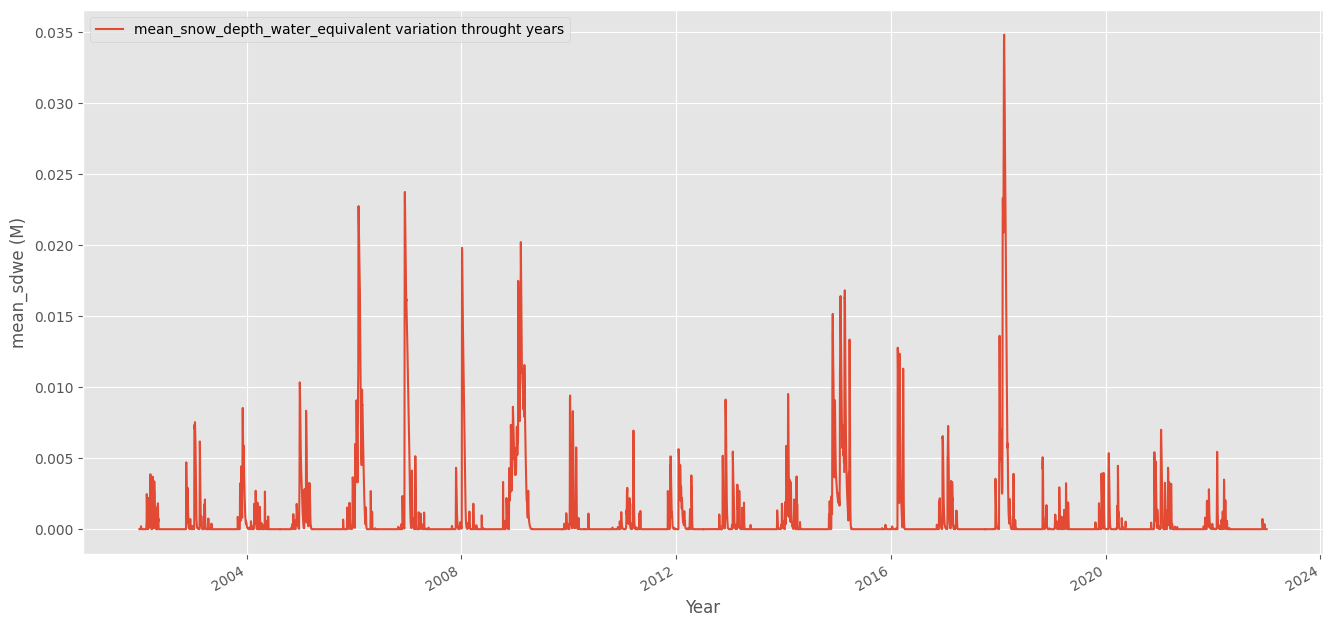

In [573]:
ax = df_3['mean_sdwe'].plot(legend=True, label="mean_snow_depth_water_equivalent variation throught years", figsize=(16, 8))
# ax = df_anom['mean_sst'].plot(legend=True, label="smoothed anom")
# ax_2 = df['mean_smlt'].plot(legend=True, label="mean_smlt variation throught years", figsize=(16, 8))
ax.set_xlabel("Year")
ax.set_ylabel("mean_sdwe (M)")

plt.show()

In [503]:
# import matplotlib.pyplot as plt

# # Assuming you have two Pandas DataFrames named 'df1' and 'df2'

# # Plotting DataFrame 1
# plt.plot(df['mean_smlt'], label='DataFrame 1',color='b')

# # Plotting DataFrame 2
# plt.plot(df_2['mean_snow_depth'], label='DataFrame 2',color='r')

# # Customize the plot
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Comparison of DataFrames')
# plt.legend()

# # Show the plot
# plt.show()


In [502]:
# plt.plot(df['mean_smlt'], label='DataFrame 1',color='b')

# # Plotting DataFrame 2
# # plt.plot(df_2['mean_snow_depth'], label='DataFrame 2',color='r')

# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming you have two Pandas DataFrames named 'df1' and 'df2'
# categories = np.arange(len(df['mean_smlt']))  # Generate category indices

# # Define the width of each bar
# bar_width = 0.35

# # Create the figure and axes
# fig, ax = plt.subplots()

# # Plot DataFrame 1
# ax.bar(categories - bar_width/2, bar_width, label='DataFrame 1', color='blue')

# # Plot DataFrame 2
# ax.bar(categories + bar_width/2, bar_width, label='DataFrame 2', color='red')

# # Customize the plot
# ax.set_xlabel('Categories')
# ax.set_ylabel('Y')
# ax.set_title('Comparison of DataFrames')
# ax.set_xticks(categories)
# ax.set_xticklabels(df_2['mean_snow_depth'])
# ax.legend()

# # Show the plot
# plt.show()


# Convert the RDD into a pandas dataframe (for visualizatio...)

### 1) Concatenate all the collect_rdd portions data in one Xarray datarray

In [510]:
collect_rdd = rdd.collect()
type(collect_rdd)

list

In [386]:
collect_rdd[:]

[<xarray.Dataset>
 Dimensions:    (longitude: 34, latitude: 20, time: 1)
 Coordinates:
   * longitude  (longitude) float32 -8.36 -8.26 -8.16 -8.06 ... -5.26 -5.16 -5.06
   * latitude   (latitude) float32 33.23 33.13 33.03 32.93 ... 31.53 31.43 31.33
   * time       (time) datetime64[ns] 2002-01-01T12:00:00
 Data variables:
     tp         (time, latitude, longitude) float32 ...
 Attributes:
     Conventions:  CF-1.6
     history:      2023-05-23 16:03:23 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...,
 <xarray.Dataset>
 Dimensions:    (longitude: 34, latitude: 20, time: 1)
 Coordinates:
   * longitude  (longitude) float32 -8.36 -8.26 -8.16 -8.06 ... -5.26 -5.16 -5.06
   * latitude   (latitude) float32 33.23 33.13 33.03 32.93 ... 31.53 31.43 31.33
   * time       (time) datetime64[ns] 2002-01-02T12:00:00
 Data variables:
     tp         (time, latitude, longitude) float32 ...
 Attributes:
     Conventions:  CF-1.6
     history:      2023-05-23 16:03:23 GMT by grib_to_netcdf-2.24.0: /opt/ecm

In [512]:
a = xr.concat(collect_rdd[:], dim='time')
type(a)

xarray.core.dataset.Dataset

In [515]:
a

<xarray.Dataset>
Dimensions:    (longitude: 34, latitude: 20, time: 7670)
Coordinates:
  * longitude  (longitude) float32 -8.36 -8.26 -8.16 -8.06 ... -5.26 -5.16 -5.06
  * latitude   (latitude) float32 33.23 33.13 33.03 32.93 ... 31.53 31.43 31.33
  * time       (time) datetime64[ns] 2002-01-01T12:00:00 ... 2022-12-31T12:00:00
Data variables:
    tp         (time, latitude, longitude) float32 5.495e-06 0.0 0.0 ... 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-23 16:03:23 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [516]:
# a['u10'].plot()

### 2) Convert the xarray.Dataset into a pandas dataframe


In [517]:
ds = a.to_dataframe()

In [518]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
tp,5215600.0,0.000415,0.001822,0.0,0.0,9.164214e-07,0.000037,0.060008


In [519]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5215600 entries, (-8.36, 33.23, Timestamp('2002-01-01 12:00:00')) to (-5.06, 31.33, Timestamp('2022-12-31 12:00:00'))
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   tp      float32
dtypes: float32(1)
memory usage: 40.1 MB


In [520]:
ds.head()

tp
longitude latitude time                             
-8.36     33.23    2002-01-01 12:00:00  5.494803e-06
                   2002-01-02 12:00:00  0.000000e+00
                   2002-01-03 12:00:00  1.767296e-04
                   2002-01-04 12:00:00  1.830980e-06
                   2002-01-05 12:00:00  9.164214e-07

In [521]:
type(ds)

pandas.core.frame.DataFrame

In [522]:
print(ds.index.names)

['longitude', 'latitude', 'time']


### dimensions values

In [523]:
latitude_values = ds.index.get_level_values('longitude').values
latitude_values

array([-8.36, -8.36, -8.36, ..., -5.06, -5.06, -5.06], dtype=float32)

In [524]:
longitude_values = ds.index.get_level_values('latitude').values
longitude_values

array([33.23, 33.23, 33.23, ..., 31.33, 31.33, 31.33], dtype=float32)

In [525]:
time_values = ds.index.get_level_values('time').values
time_values

array(['2002-01-01T12:00:00.000000000', '2002-01-02T12:00:00.000000000',
       '2002-01-03T12:00:00.000000000', ...,
       '2022-12-29T12:00:00.000000000', '2022-12-30T12:00:00.000000000',
       '2022-12-31T12:00:00.000000000'], dtype='datetime64[ns]')

### variable values

In [526]:
tp_values = ds['tp'].values
# u10_values = ds['tp'].values

tp_values

array([5.4948032e-06, 0.0000000e+00, 1.7672963e-04, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [527]:
tp = ds['tp']
# u10 = ds['tp']

tp_head = tp.head(1)

tp_head

longitude  latitude  time               
-8.36      33.23     2002-01-01 12:00:00    0.000005
Name: tp, dtype: float32

In [528]:
type(tp)

pandas.core.series.Series

# visualization

## u10 = fct (time)  2002 to 2022

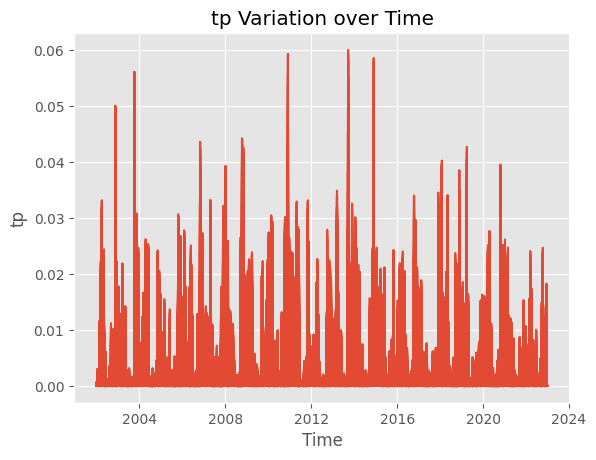

In [529]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Increase the path chunksize limit
mpl.rcParams['agg.path.chunksize'] = 1000

# Assuming you have a Pandas DataFrame named 'df' with the 'u10' variable and a time index

# Plotting 'tp' variable as a function of the time index
tp_values = [value for value in ds['tp'].values]

plt.plot(ds.index.get_level_values('time').values, tp_values)
plt.xlabel('Time')
plt.ylabel('tp')
plt.title('tp Variation over Time')
plt.show()

## tp = fct (time)  2002

In [530]:
condition = ds.index.get_level_values('time').year ==2002
tp_2002 = ds[condition]
tp_2002

tp
longitude latitude time                             
-8.36     33.23    2002-01-01 12:00:00  5.494803e-06
                   2002-01-02 12:00:00  0.000000e+00
                   2002-01-03 12:00:00  1.767296e-04
                   2002-01-04 12:00:00  1.830980e-06
                   2002-01-05 12:00:00  9.164214e-07
...                                              ...
-5.06     31.33    2002-12-27 12:00:00  9.164214e-07
                   2002-12-28 12:00:00  9.164214e-07
                   2002-12-29 12:00:00  9.164214e-07
                   2002-12-30 12:00:00  0.000000e+00
                   2002-12-31 12:00:00  0.000000e+00

[248200 rows x 1 columns]

In [531]:
# date = u10_2002.index.get_level_values('time').values
date = tp_2002.index.get_level_values('time').month.values

date

array([ 1,  1,  1, ..., 12, 12, 12], dtype=int32)

In [532]:
type(date)

numpy.ndarray

In [533]:
len(date)

248200

In [534]:
time_year = [t for t in date]
time_year

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,


In [535]:
tp_2002_values = []
for value in tp_2002.values:
    for i in value:
        tp_2002_values.append(i)
    
tp_2002_values

[5.494803e-06,
 0.0,
 0.00017672963,
 1.8309802e-06,
 9.164214e-07,
 0.0,
 7.966533e-05,
 2.7474016e-06,
 9.164214e-07,
 0.0,
 5.8604404e-05,
 9.164214e-07,
 0.0,
 9.164214e-07,
 7.3257834e-06,
 2.7474016e-06,
 0.0,
 0.0,
 7.3257834e-06,
 0.00016024709,
 0.0,
 9.164214e-07,
 0.0,
 0.00030401163,
 9.164214e-07,
 0.0,
 9.164214e-07,
 9.164214e-07,
 2.7474016e-06,
 9.164214e-07,
 2.7474016e-06,
 0.0,
 0.0,
 9.164214e-07,
 8.699112e-05,
 1.8309802e-06,
 0.00048715062,
 0.0,
 9.164214e-07,
 0.0,
 2.2891909e-05,
 9.164214e-07,
 9.164214e-07,
 9.164214e-07,
 9.164214e-07,
 5.5857003e-05,
 0.00012087263,
 0.001355229,
 0.0020392537,
 4.2121857e-05,
 1.8309802e-06,
 0.0,
 9.164214e-07,
 0.0,
 9.164214e-07,
 3.663823e-06,
 7.3257834e-06,
 1.3735145e-05,
 2.7474016e-06,
 0.0013808683,
 0.0007133279,
 0.0023286138,
 0.004937431,
 0.0012682378,
 0.0022361279,
 0.00023533404,
 1.8309802e-06,
 1.8309802e-06,
 0.0,
 0.0,
 0.0,
 0.0042808764,
 0.0013030358,
 2.9303133e-05,
 0.006475799,
 4.39547e-05,
 

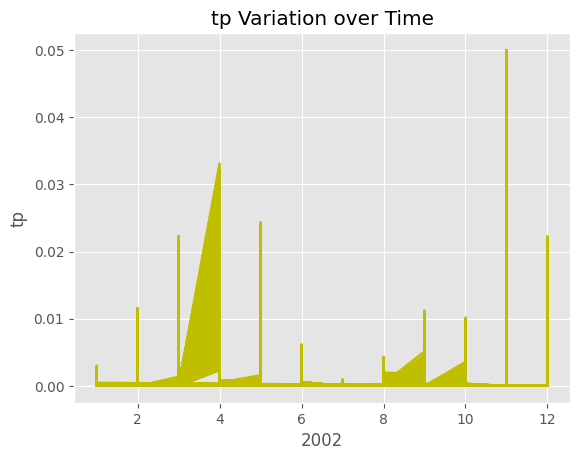

In [536]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Increase the path chunksize limit
mpl.rcParams['agg.path.chunksize'] = 1000

# Assuming you have a Pandas DataFrame named 'df' with the 'u10' variable and a time index

# Plotting 'u10' variable as a function of the time index
# u10_2002_values = [value for value in u10_2002.values]

plt.plot(time_year , tp_2002_values,color='y')
plt.xlabel('2002')
plt.ylabel('tp')
plt.title('tp Variation over Time')
plt.show()

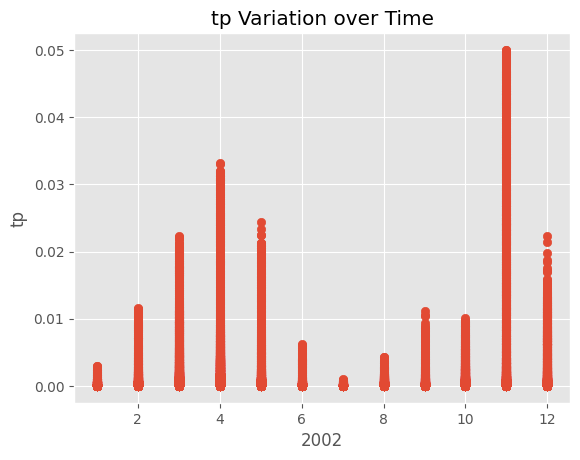

In [537]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Increase the path chunksize limit
mpl.rcParams['agg.path.chunksize'] = 1000

# Assuming you have a Pandas DataFrame named 'df' with the 'u10' variable and a time index

# Plotting 'u10' variable as a function of the time index
# u10_2002_values = [value for value in u10_2002.values]

plt.scatter(time_year , tp_2002_values)
plt.xlabel('2002')
plt.ylabel('tp')
plt.title('tp Variation over Time')
plt.show()

## Bar plot

In [538]:
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# # Increase the path chunksize limit
# mpl.rcParams['agg.path.chunksize'] = 1000

# # Assuming you have a Pandas DataFrame named 'df' with the 'u10' variable and a time index

# # Plotting 'u10' variable as a function of the time index
# # u10_2002_values = [value for value in u10_2002.values]

# plt.bar(time_year , u10_2002_values)
# plt.xlabel('2002')
# plt.ylabel('u10')
# plt.title('u10 Variation over Time')
# plt.show()

## Area Plot

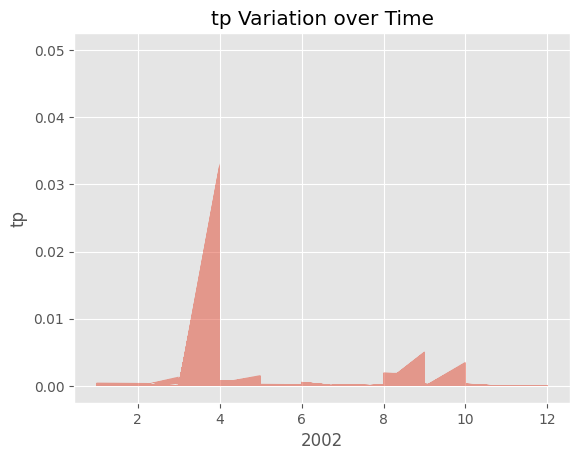

In [539]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Increase the path chunksize limit
mpl.rcParams['agg.path.chunksize'] = 1000

# Assuming you have a Pandas DataFrame named 'df' with the 'u10' variable and a time index

# Plotting 'u10' variable as a function of the time index
# u10_2002_values = [value for value in u10_2002.values]

plt.fill_between(time_year , tp_2002_values, alpha=0.5)
plt.xlabel('2002')
plt.ylabel('tp')
plt.title('tp Variation over Time')
plt.show()

## Box Plot

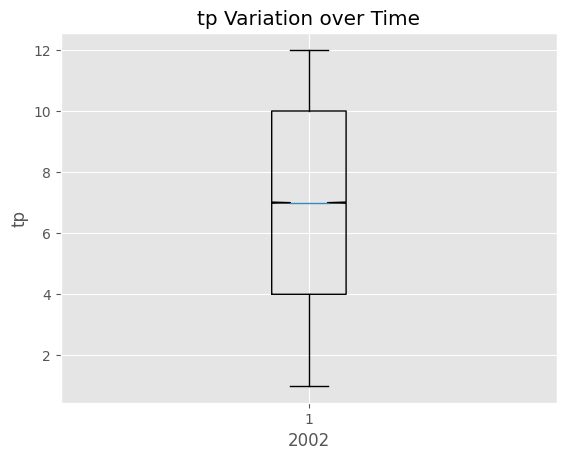

In [555]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Increase the path chunksize limit
mpl.rcParams['agg.path.chunksize'] = 1000

# Assuming you have a Pandas DataFrame named 'df' with the 'u10' variable and a time index

# Plotting 'u10' variable as a function of the time index
# u10_2002_values = [value for value in u10_2002.values]

plt.boxplot(time_year , tp_2002_values)
plt.xlabel('2002')
plt.ylabel('tp')
plt.title('tp Variation over Time')
plt.show()

## Line Graph

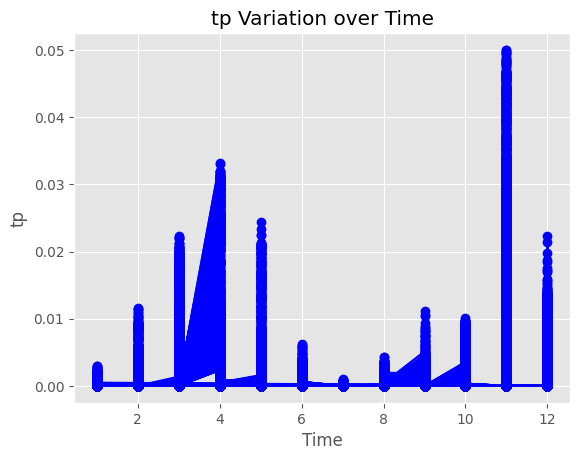

In [546]:

import matplotlib.pyplot as plt

# Assuming you have a Pandas DataFrame named 'df' with the 'u10' variable and a time index

# Plotting 'u10' variable as a line graph
plt.plot(time_year, tp_2002_values, marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('tp')
plt.title('tp Variation over Time')
plt.show()


## Pie Chart (u10 by years)

In [542]:
# import matplotlib.pyplot as plt

# # Assuming you have a Pandas DataFrame named 'df' with the 'u10' variable and a time index

# # Calculating the sum of 'u10' values for each year
# date = u10_2002.index.get_level_values('time').year
# date = pd.to_datetime(date)

# u10_sum_by_year = ds.groupby(date)['u10'].sum()

# # Creating the pie chart
# plt.pie(u10_sum_by_year, labels=u10_sum_by_year.index, autopct='%1.1f%%')
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
# plt.title('u10 Variation by Year')
# plt.show()

In [543]:

# ds = collect_rdd.to_dataframe()

In [550]:
!pip install ncplot 


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 7.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 14.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 26.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 23.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.4/400.4 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 24.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 27.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 18.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 25.7 MB/s eta 0:00:00
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59440 sha256=895f8b73a820c34853c6a35baecbb2fc77087b2b57f4d8b965ab23f36cd66530
  Stored in directory: /root/.cache/pip/wheels/35/c6/63/a3c12ecc9fdea10a593271de5c56481b427ad4049b90a176e1
Successfully built datashape


In [ ]:
total_precipitation
_10m_u = "/app/data/10m_u_component_of_wind_2002_2022.nc"
_10m_v = "/app/data/10m_v_component_of_wind_2002_2022.nc"
_2m_t = "/app/data/2m_temperature_2002_2022.nc"
snow_cover = "/app/data/snow_cover_2002_2022.nc"
snow_density = "/app/data/snow_density_2002_2022.nc"
snow_depth = "/app/data/snow_depth_2002_2022.nc"
sdwe = "/app/data/snow_depth_water_equivalent_2002_2022.nc"
snowfall=  "/app/data/snowfall_2002_2022.nc"
snowmelt = "/app/data/snowmelt_2002_2022.nc"
surface_pressure = "/app/data/surface_pressure_2002_2022.nc"
total_precipitation = "/app/data/total_precipitation_2002_2022.nc"

In [553]:
import ncplot.xarray
import xarray as xr

ds = xr.open_dataset(total_precipitation)

ds.ncplot.view()


:DynamicMap   [time]
   :Image   [longitude,latitude]   (tp)

# user's requests (APIs)

In [548]:
import ipywidgets as widgets

# Assuming you have a Pandas DataFrame named 'df' with fields 'field1', 'field2', and a date column 'date'

# Create dropdown widgets date selection
date_dropdown = widgets.Dropdown(options=ds.index.get_level_values('time').year.values, description='Select Date:')


# Create an output widget to display the selected data
output = widgets.Output()


# Define a callback function to handle changes in dropdown selection
def handle_selection(change):
    selected_date = date_dropdown.value
   
    # Filter the DataFrame based on the selected field and date    
    condition = ds.index.get_level_values('time').year == selected_date
    tp_for_selected_date = ds[condition]

    # Clear the output widget and display the filtered data
    with output:
        output.clear_output()
        display(tp_for_selected_date)

        
        
# Register the callback function to handle changes in dropdown selection
date_dropdown.observe(handle_selection, 'value')

# Display the dropdown widgets
display(widgets.HBox([field_dropdown, date_dropdown]))
display(output)


# ------------------------------------------------------

deuxieme choix pour la lecture des données NetCDF

# read NetCDF files using Xarray

In [86]:
dataset = xr.open_dataset(smlt)
print(dataset)

<xarray.Dataset>
Dimensions:    (longitude: 34, latitude: 20, time: 7670)
Coordinates:
  * longitude  (longitude) float32 -8.36 -8.26 -8.16 -8.06 ... -5.26 -5.16 -5.06
  * latitude   (latitude) float32 33.23 33.13 33.03 32.93 ... 31.53 31.43 31.33
  * time       (time) datetime64[ns] 2002-01-01T12:00:00 ... 2022-12-31T12:00:00
Data variables:
    smlt       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-23 11:03:06 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...


In [87]:
type(dataset)

xarray.core.dataset.Dataset

In [94]:
dataset['smlt'].values

array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.000

# xarray Dataset to pandas DataFrame

In [88]:
df = dataset['smlt'].to_dataframe()


In [89]:
type(df)

pandas.core.frame.DataFrame

In [90]:
df

smlt
time                latitude longitude      
2002-01-01 12:00:00 33.23    -8.36       0.0
                             -8.26       0.0
                             -8.16       0.0
                             -8.06       0.0
                             -7.96       0.0
...                                      ...
2022-12-31 12:00:00 31.33    -5.46       0.0
                             -5.36       0.0
                             -5.26       0.0
                             -5.16       0.0
                             -5.06       0.0

[5215600 rows x 1 columns]

In [32]:
import pandas as pd
%matplotlib inline
import matplotlibrdd.count()
tt
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt


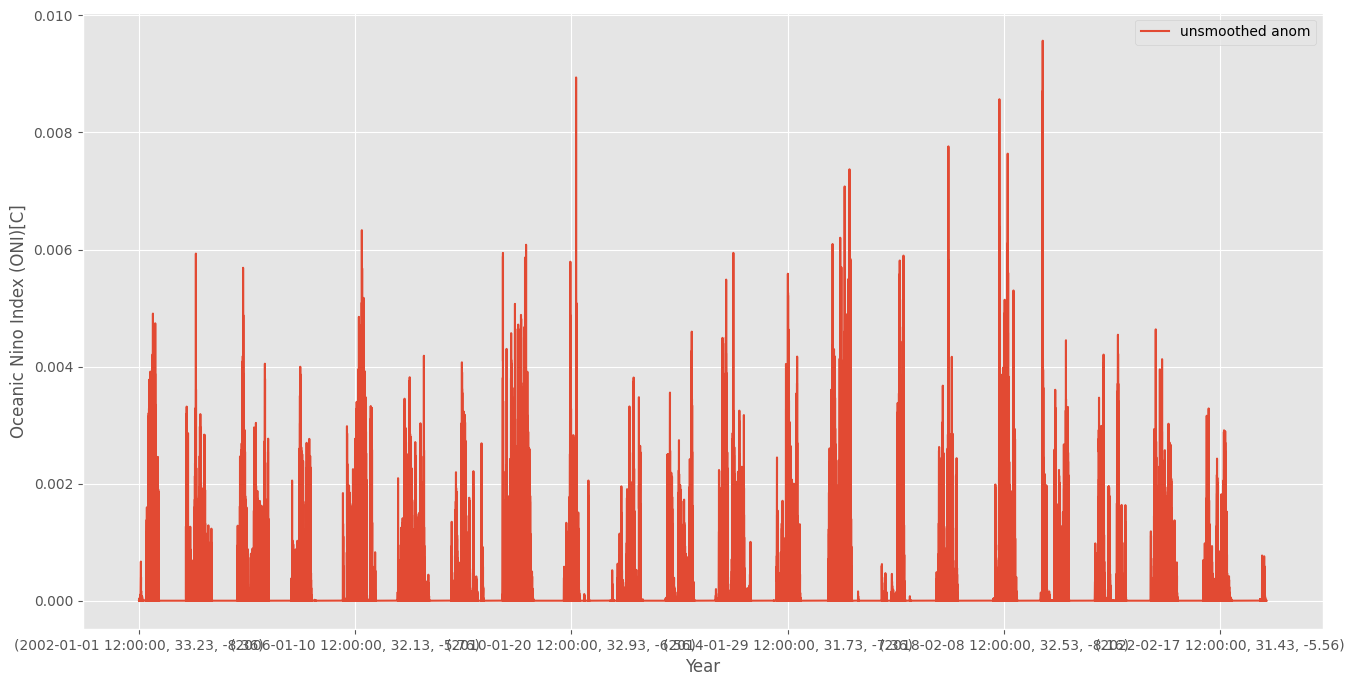

In [33]:
ax = df['smlt'].plot(legend=True, label="unsmoothed anom", figsize=(16, 8))
# ax = df_anom['mean_sst'].plot(legend=True, label="smoothed anom")
ax.set_xlabel("Year")
ax.set_ylabel("Oceanic Nino Index (ONI)[C]")
plt.show()

# Pandas Dataframe To Spark DataFrame

In [44]:
spark_df = spark.createDataFrame(df)

In [47]:
spark_df.show()

23/05/23 12:52:10 WARN TaskSetManager: Stage 3 contains a task of very large size (1176 KiB). The maximum recommended task size is 1000 KiB.


+----+
|smlt|
+----+
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
| 0.0|
+----+
only showing top 20 rows



In [62]:
type(spark_df)

pyspark.sql.dataframe.DataFrame

In [61]:

# from pyspark.sql import SparkSession

# spark_0 = SparkSession.builder.getOrCreate()

# # Read NetCDF file as a DataFrame
# dataframe = spark_0.read.format("netcdf").option("path", "../data/data.nc").load()

# # Perform further operations on the DataFrame
# dataframe.show()
# # ... perform additional transformations, aggregations, etc.

# # Close the Spark session
# # spark_0.stop()
